In [1]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

!pip install pyLDAvis
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [2]:

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim

In [3]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [4]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [5]:
df.head()

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...
3,2020-05-31,mild neu,0.576460,thanks
4,2020-05-31,mild neu,0.629136,bigger w


In [6]:
!pip install contractions

In [7]:

# import nltk
# nltk.download('punkt_tab')
# !pip install -U spacy torch transformers
import spacy


In [8]:
# !python -m spacy download en_core_web_trf


In [9]:
df.shape[0]

87034

In [10]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [11]:
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()


,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [12]:
df.shape[0]

86446

In [13]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'mild pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
start_date = '2020-01-01'
end_date = '2020-05-31'

# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

<ipython-input-13-4052be87efef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
7,2020-05-31,mild pos,0.598285,good luck booked one discount point fare trip ...,"[good, luck, book, discount, point, fare, trip...",good luck book discount point fare trip europe...
24,2020-05-31,mild pos,0.588926,thanks pointing gambling right using point sin...,"[thank, point, gambling, right, point, fare, c...",thank point gambling right point fare cashchea...
36,2020-05-30,mild pos,0.729096,course feel free spent ton time,"[course, feel, free, spend, ton, time]",course feel free spend ton time
69,2020-05-29,mild pos,0.687201,kind shocked able find singapore award availab...,"[kind, shocked, able, find, singapore, award, ...",kind shocked able find singapore award availab...
81,2020-05-29,mild pos,0.741639,nice saved point night previously booked reser...,"[nice, save, point, night, previously, book, r...",nice save point night previously book reservation


In [14]:
high_pos_df.shape[0]

1800

      token  count
0      good    537
1    flight    525
2     point    371
3     thank    327
4      book    323
5      time    265
6       fly    256
7      well    249
8      like    241
9       get    240
10     mile    225
11     look    209
12      day    205
13   travel    201
14     trip    199
15     nice    196
16     find    192
17  airline    188
18       go    186
19    hotel    183
20     year    178
21    think    170
22      way    170
23     want    169
24     stay    166
25   ticket    163
26    award    155
27     know    149
28    great    149
29    night    144


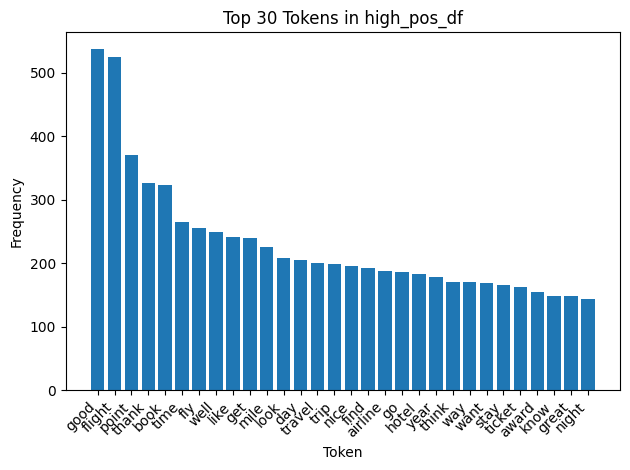

In [15]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [16]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


35696 words total, with a vocabulary size of 5142
Max reddit post length is 223 tokens
Mean reddit post length is 19.83 tokens
Median reddit post length is 13 tokens


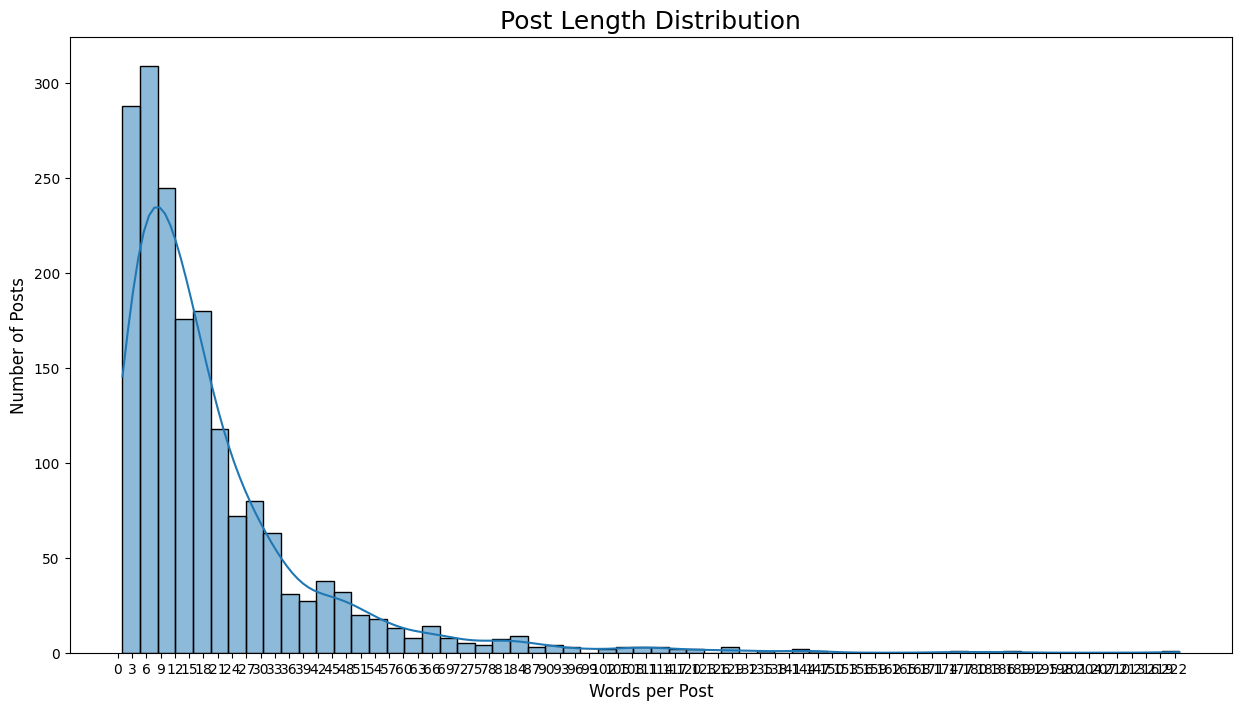

In [17]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [18]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim



In [19]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

#    min_count=3 → only consider pairs that appear in ≥3 docs
#    threshold=50 → higher threshold = fewer, more confident bigrams
# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                               tokens  \
7   [good, luck, book, discount, point, fare, trip...   
24  [thank, point, gambling, right, point, fare, c...   
36             [course, feel, free, spend, ton, time]   
69  [kind, shocked, able, find, singapore, award, ...   
81  [nice, save, point, night, previously, book, r...   

                                        bigram_tokens  \
7   [good, luck, book, discount, point, fare, trip...   
24  [thank, point, gambling, right, point, fare, c...   
36             [course, feel, free, spend, ton, time]   
69  [kind, shocked, able, find, singapore, award, ...   
81  [nice, save, point, night, previously, book, r...   

                                       trigram_tokens  
7   [good, luck, book, discount, point, fare, trip...  
24  [thank, point, gambling, right, point, fare, c...  
36             [course, feel, free, spend, ton, time]  
69  [kind, shocked, able, find, singapore, award, ...  
81  [nice, save, point, night, pre

In [20]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   397
Rows with trigrams:  14
Rows with no n-grams: 1403


In [21]:
high_pos_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
7,2020-05-31,mild pos,0.598285,good luck booked one discount point fare trip ...,"[good, luck, book, discount, point, fare, trip...",good luck book discount point fare trip europe...,"[good, luck, book, discount, point, fare, trip...","[good, luck, book, discount, point, fare, trip...",False,False
24,2020-05-31,mild pos,0.588926,thanks pointing gambling right using point sin...,"[thank, point, gambling, right, point, fare, c...",thank point gambling right point fare cashchea...,"[thank, point, gambling, right, point, fare, c...","[thank, point, gambling, right, point, fare, c...",False,False
36,2020-05-30,mild pos,0.729096,course feel free spent ton time,"[course, feel, free, spend, ton, time]",course feel free spend ton time,"[course, feel, free, spend, ton, time]","[course, feel, free, spend, ton, time]",False,False
69,2020-05-29,mild pos,0.687201,kind shocked able find singapore award availab...,"[kind, shocked, able, find, singapore, award, ...",kind shocked able find singapore award availab...,"[kind, shocked, able, find, singapore, award, ...","[kind, shocked, able, find, singapore, award, ...",True,False
81,2020-05-29,mild pos,0.741639,nice saved point night previously booked reser...,"[nice, save, point, night, previously, book, r...",nice save point night previously book reservation,"[nice, save, point, night, previously, book, r...","[nice, save, point, night, previously, book, r...",False,False


In [22]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1800
Number of rows in 'trigram_tokenized' column: 1800


In [23]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_bigrams = itertools.chain.from_iterable(high_pos_df['bigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
bigram_counts = Counter(
    token for token in all_bigrams
    if isinstance(token, str) and token.count('_') == 1
)

# 3) How many unique trigrams?
total_unique_bigrams = len(bigram_counts)
print(f"Total number of unique bigrams: {total_unique_bigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count:,}")


Total number of unique bigrams: 86

Most common bigrams:
business_class: 37
credit_card: 28
park_hyatt: 18
award_space: 17
chase_portal: 17
premium_cabin: 16
year_ago: 15
round_trip: 15
sound_like: 14
air_france: 13


In [24]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 2

Most common trigrams:
stop_reply_comment: 9
free_night_cert: 6


In [25]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [26]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=4,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=200,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [27]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [28]:
# from gensim.models import CoherenceModel
# #
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [29]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [30]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [31]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

#
texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta, seed))
    # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
      f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']



print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 9, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.5827, Coherence: 0.4660, Alpha: [0.02960799 0.10186667 0.10609742 0.8037992  0.12750857 0.0511378
 0.0458743  0.06344463 0.13017115], Eta: [0.10470013 0.10656158 0.12168806 ... 0.10398371 0.10398435 0.10398263]

Results:
     num_topics  chunksize  passes  iterations  perplexity  coherence  \
0             2       1000     100          50   -7.297122   0.545094   
1             2       1000     100         100   -7.294078   0.527432   
2             2       1000     100         200   -7.295213   0.519969   
3             2       1000     200          50   -7.294145   0.543978   
4             2       1000     200         100   -7.290879   0.531529   
..          ...        ...     ...         ...         ...        ...   
211           9       1000     200         100   -7.592870   0.475494   
212           9       1000     200         200   -7.589571   0.456995   
213           9       1000     260          5

In [32]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5856
 Perplexity: -7.3135
 Alpha (per topic): [0.04267415 0.04885703 0.01976112]
 Eta   (per word):  [0.31782386 0.82589906 1.2129632  ... 0.30315584 0.30315536 0.30318114]


In [34]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary_1st_mild_pos.txt')


In [35]:
# verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [36]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.022*"flight" + 0.017*"good" + 0.012*"fly" + 0.009*"airline" + '
  '0.008*"point" + 0.008*"book" + 0.008*"mile" + 0.007*"well" + 0.007*"seat" + '
  '0.007*"way"'),
 (1,
  '0.018*"thank" + 0.014*"point" + 0.012*"good" + 0.011*"flight" + '
  '0.011*"book" + 0.010*"get" + 0.007*"year" + 0.007*"time" + 0.006*"hotel" + '
  '0.006*"night"'),
 (2,
  '0.008*"time" + 0.008*"good" + 0.008*"stay" + 0.007*"well" + 0.007*"hotel" + '
  '0.007*"nice" + 0.007*"day" + 0.006*"room" + 0.006*"like" + 0.005*"want"')]

Sample doc-topic distribution for doc 0:
[(1, 0.99884534)]


In [37]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [38]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  flight (0.0224)
  good (0.0172)
  fly (0.0120)
  airline (0.0087)
  point (0.0084)
  book (0.0083)
  mile (0.0080)
  well (0.0075)
  seat (0.0073)
  way (0.0070)
  find (0.0068)
  look (0.0067)
  pretty (0.0061)
  time (0.0057)
  travel (0.0055)
  cheap (0.0053)
  award (0.0053)
  economy (0.0052)
  route (0.0049)
  like (0.0049)
  ticket (0.0049)
  transfer (0.0048)
  trip (0.0047)
  go (0.0046)
  availability (0.0045)
  united (0.0045)
  cash (0.0043)
  option (0.0042)
  want (0.0041)
  price (0.0041)

Topic 2:
  thank (0.0179)
  point (0.0138)
  good (0.0123)
  flight (0.0113)
  book (0.0110)
  get (0.0097)
  year (0.0073)
  time (0.0070)
  hotel (0.0065)
  night (0.0063)
  like (0.0059)
  look (0.0057)
  cancel (0.0056)
  stay (0.0056)
  mile (0.0055)
  travel (0.0055)
  day (0.0055)
  refund (0.0053)
  ticket (0.0052)
  go (0.0050)
  hope (0.0048)
  think (0.0047)
  work (0.0045)
  know (0.0045)
  trip (0.0044)
  status (0.0043)
  well (0

In [39]:
# import gensim.corpora as corpora
# # # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# # ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# # #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [40]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50, 100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
#     # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

# print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
#       f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']


# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [41]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [42]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [43]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [44]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [45]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [46]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [47]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'mild neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
start_date = '2020-01-01'
end_date = '2020-05-31'

# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

<ipython-input-47-9c5104ab297f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
27,2020-05-31,mild neg,0.604601,moot point hawaii doesnt ai like op wanting,"[moot, point, hawaii, like, want]",moot point hawaii like want
40,2020-05-30,mild neg,0.583620,gt time square hotel nyeat crowne plaza seriou...,"[time, square, hotel, nyeat, crowne, plaza, se...",time square hotel nyeat crowne plaza seriously...
53,2020-05-29,mild neg,0.559274,really depends goal using point merchandise ne...,"[depend, goal, point, merchandise, great, deal...",depend goal point merchandise great deal trave...
54,2020-05-29,mild neg,0.641406,obviously silly,"[obviously, silly]",obviously silly
58,2020-05-29,mild neg,0.581786,got error,"[get, error]",get error


In [48]:
high_neg_first_wave_df.shape[0]

2146

      token  count
0    flight    879
1    cancel    558
2   airline    473
3    refund    378
4      book    330
5    travel    303
6      like    296
7     point    288
8    ticket    288
9    people    276
10     time    272
11       go    245
12      get    230
13      fly    220
14      try    219
15    think    209
16      day    196
17      pay    196
18      bad    196
19     know    195
20     want    190
21      say    180
22     mile    173
23      way    168
24   change    166
25     year    159
26     need    159
27     find    157
28     look    155
29     work    155


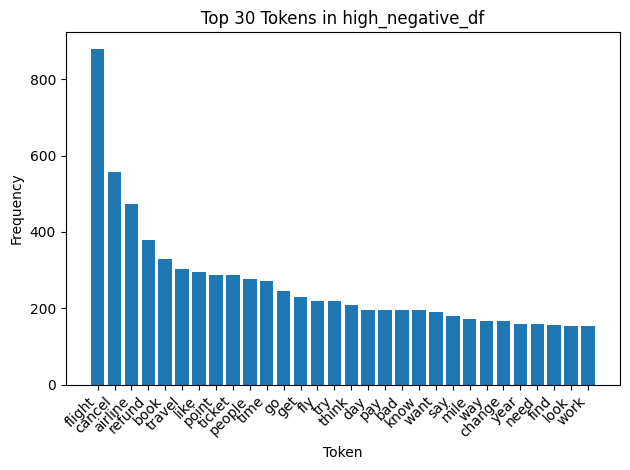

In [49]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [50]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


39452 words total, with a vocabulary size of 5454
Max reddit post length is 195 tokens
Mean reddit post length is 18.38 tokens
Median reddit post length is 13 tokens


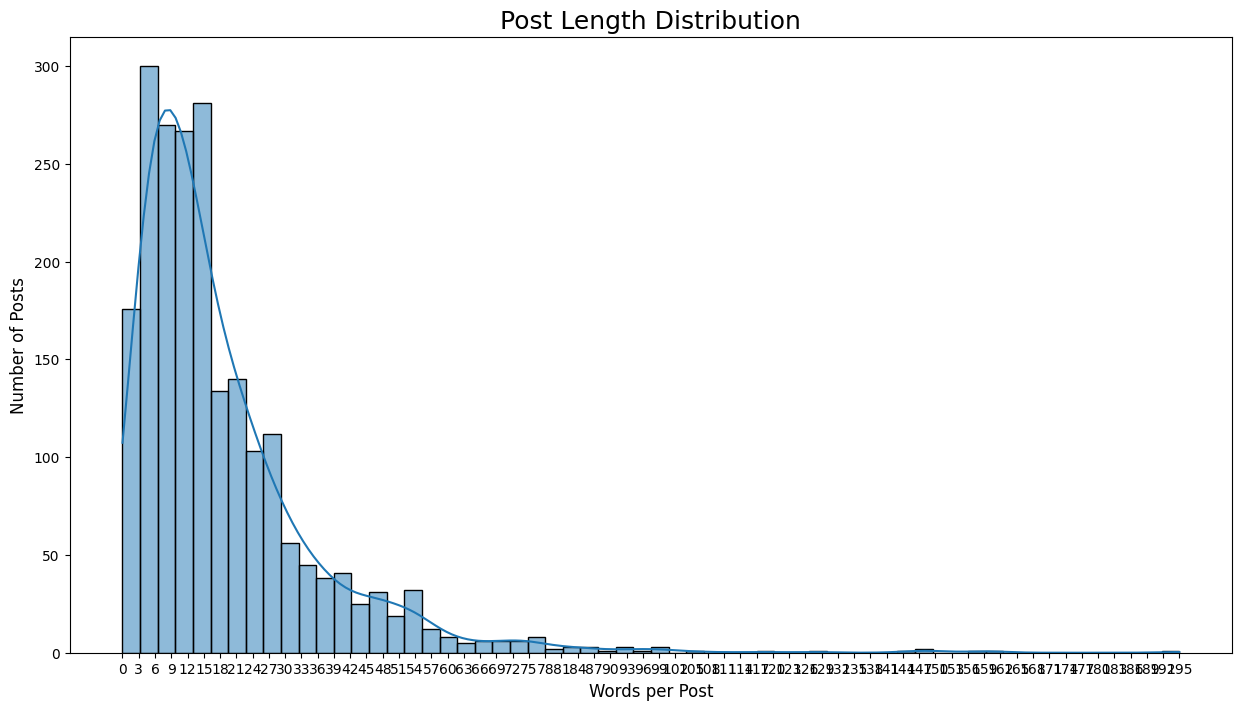

In [51]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [52]:
#!pip install  gensim


In [53]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# #
# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                               tokens  \
27                  [moot, point, hawaii, like, want]   
40  [time, square, hotel, nyeat, crowne, plaza, se...   
53  [depend, goal, point, merchandise, great, deal...   
54                                 [obviously, silly]   
58                                       [get, error]   

                                        bigram_tokens  \
27                  [moot, point, hawaii, like, want]   
40  [time, square, hotel, nyeat, crowne, plaza, se...   
53  [depend, goal, point, merchandise, great, deal...   
54                                 [obviously, silly]   
58                                       [get, error]   

                                       trigram_tokens  
27                  [moot, point, hawaii, like, want]  
40  [time, square, hotel, nyeat, crowne, plaza, se...  
53  [depend, goal, point, merchandise, great, deal...  
54                                 [obviously, silly]  
58                                

In [54]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   411
Rows with trigrams:  6
Rows with no n-grams: 1735


In [55]:
high_neg_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
27,2020-05-31,mild neg,0.604601,moot point hawaii doesnt ai like op wanting,"[moot, point, hawaii, like, want]",moot point hawaii like want,"[moot, point, hawaii, like, want]","[moot, point, hawaii, like, want]",False,False
40,2020-05-30,mild neg,0.583620,gt time square hotel nyeat crowne plaza seriou...,"[time, square, hotel, nyeat, crowne, plaza, se...",time square hotel nyeat crowne plaza seriously...,"[time, square, hotel, nyeat, crowne, plaza, se...","[time, square, hotel, nyeat, crowne, plaza, se...",False,False
53,2020-05-29,mild neg,0.559274,really depends goal using point merchandise ne...,"[depend, goal, point, merchandise, great, deal...",depend goal point merchandise great deal trave...,"[depend, goal, point, merchandise, great, deal...","[depend, goal, point, merchandise, great, deal...",False,False
54,2020-05-29,mild neg,0.641406,obviously silly,"[obviously, silly]",obviously silly,"[obviously, silly]","[obviously, silly]",False,False
58,2020-05-29,mild neg,0.581786,got error,"[get, error]",get error,"[get, error]","[get, error]",False,False


In [56]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 2146
Number of rows in 'trigram_tokenized' column: 2146


In [57]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 2

Most common trigrams:
avoid_iranian_airspace: 4
redeposit_fee_waive: 3


In [58]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [59]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                           chunksize=250,
#                                        passes=100,
#                                         iterations= 200,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [60]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [61]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [62]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [63]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [300]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta, seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.3766, Coherence: 0.5120, Alpha: [0.06227028 0.1275893 ], Eta: [ 1.9233229  32.62804     0.4700469  ...  0.60307443  0.60307443
  0.7131934 ]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.3768, Coherence: 0.5173, Alpha: [0.06230905 0.1278424 ], Eta: [ 1.9223727  32.564194    0.4699134  ...  0.60264343  0.60264343
  0.7126225 ]


Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.3805, Coherence: 0.4962, Alpha: [0.06324609 0.1400986 ], Eta: [ 1.907035   32.07243     0.46821508 ...  0.5999443   0.5999443
  0.7090809 ]


Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.3654, Coherence: 0.5220, Alpha: [0.05444568 0.11196075], Eta: [ 1.9889296  33.358696    0.47575003 ...  0.6118798   0.6118798
  0.7247476 ]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 100, Perplexity: -7.3663, Coherence: 0.5220, Alpha: [0.05595165 0.11481941], Eta: [ 1.9815164  33.200893    0.47496203 ...  0.61058134  0.61058134
  0.723041  ]


Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 200, Perplexity: -7.3678, Coherence: 0.5092, Alpha: [0.05618742 0.1226557 ], Eta: [ 1.9808967  33.09445     0.47487044 ...  0.610387    0.610387
  0.72278297]


Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 50, Perplexity: -7.3620, Coherence: 0.5220, Alpha: [0.0519831  0.10796075], Eta: [ 2.0078363  33.616318    0.47752467 ...  0.6145151   0.6145151
  0.7282045 ]
Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 100, Perplexity: -7.3632, Coherence: 0.5220, Alpha: [0.05501853 0.11276618], Eta: [ 1.9961593  33.390934    0.47618717 ...  0.61247313  0.61247313
  0.72552365]


Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 200, Perplexity: -7.3647, Coherence: 0.5092, Alpha: [0.05400539 0.11797848], Eta: [ 1.997862   33.313248    0.47644868 ...  0.61283433  0.61283433
  0.725995  ]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.4536, Coherence: 0.4884, Alpha: [0.05072817 0.3558998  0.19892229], Eta: [0.58586437 2.3311749  0.28768507 ... 0.32277405 0.32277405 0.34626406]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.4560, Coherence: 0.4795, Alpha: [0.0476903  0.37124872 0.21959394], Eta: [0.5984407  3.043885   0.28772488 ... 0.32266378 0.32266378 0.34614083]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.4519, Coherence: 0.4824, Alpha: [0.04429324 0.35569805 0.2247929 ], Eta: [0.5822876  3.1571138  0.28759906 ... 0.32202092 0.32202092 0.34540957]
Num Topics: 3, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.4382, Coherence: 0.4858, Alpha: [0.04154907 0.

Num Topics: 9, Chunksize: 300, Passes: 260, Iterations: 200, Perplexity: -7.6524, Coherence: 0.5166, Alpha: [0.13162392 0.28625414 0.28522825 0.33018723 0.7924892  0.2997724
 3.9801538  0.13377991 1.2881172 ], Eta: [0.12198377 0.13286315 0.10450606 ... 0.1061158  0.1061158  0.10701973]


Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.3760, Coherence: 0.5261, Alpha: [0.06121721 0.1161207 ], Eta: [ 1.9299152  32.90531     0.47117943 ...  0.6046294   0.6046294
  0.71522874]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.3756, Coherence: 0.5268, Alpha: [0.06037561 0.11914695], Eta: [ 1.9291037  32.83637     0.47087708 ...  0.6042978   0.6042978
  0.71479684]


Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.3760, Coherence: 0.5261, Alpha: [0.0603408 0.1215039], Eta: [ 1.9305029  32.847073    0.47103918 ...  0.6044838   0.6044838
  0.71503854]


Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.3651, Coherence: 0.5237, Alpha: [0.05582773 0.1085293 ], Eta: [ 1.99035   33.55994    0.4762516 ...  0.6123296  0.6123296  0.7253308]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 100, Perplexity: -7.3652, Coherence: 0.5237, Alpha: [0.05435975 0.10860676], Eta: [ 1.9882827  33.46166     0.4758468  ...  0.6120246   0.6120246
  0.72493833]


Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 200, Perplexity: -7.3653, Coherence: 0.5237, Alpha: [0.05397478 0.10902671], Eta: [ 1.990785   33.519764    0.47615522 ...  0.61247736  0.61247736
  0.72553223]


Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 50, Perplexity: -7.3604, Coherence: 0.5368, Alpha: [0.05218879 0.10088081], Eta: [ 2.0267172  34.18627     0.48012674 ...  0.61654687  0.61654687
  0.7308231 ]
Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 100, Perplexity: -7.3621, Coherence: 0.5237, Alpha: [0.05300476 0.10647369], Eta: [ 2.0063076  33.696835    0.47744092 ...  0.614373    0.614373
  0.7280183 ]


Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 200, Perplexity: -7.3621, Coherence: 0.5368, Alpha: [0.05242823 0.10667409], Eta: [ 2.0094829  33.76213     0.47782937 ...  0.61496043  0.61496043
  0.72878945]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.4562, Coherence: 0.4823, Alpha: [0.15421735 0.30360213 0.06179932], Eta: [ 0.61654955 12.149766    0.28929308 ...  0.32420358  0.32420358
  0.34789014]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.4529, Coherence: 0.5095, Alpha: [0.14549723 0.34168229 0.06662823], Eta: [ 0.62265587 15.449892    0.29100654 ...  0.32636133  0.32636133
  0.35034382]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.4577, Coherence: 0.5178, Alpha: [0.16711833 0.3651646  0.0702116 ], Eta: [ 0.61240226 15.158637    0.28889725 ...  0.32377374  0.32377374
  0.34740123]
Num Topics: 3, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.4387, Coherence: 0.4894, 

Num Topics: 9, Chunksize: 300, Passes: 260, Iterations: 200, Perplexity: -7.6722, Coherence: 0.4811, Alpha: [1.9370147  3.0220497  0.35256222 0.7485167  0.18815282 0.23449543
 0.57987124 0.42882448 0.25622398], Eta: [0.10553188 0.10947444 0.10302418 ... 0.1045367  0.1045367  0.10541427]


Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.3822, Coherence: 0.5719, Alpha: [0.12224834 0.08599984], Eta: [ 1.9185512  33.82419     0.61005634 ...  0.6072296   0.6072296
  0.71859354]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.4242, Coherence: 0.4825, Alpha: [0.03729287 0.24401954], Eta: [0.7104193  2.9701488  0.46291217 ... 0.58974016 0.58974016 0.695649  ]


Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.4097, Coherence: 0.4927, Alpha: [0.03980837 0.2056062 ], Eta: [ 0.745972   19.307339    0.46741933 ...  0.5964882   0.5964882
  0.7044768 ]


Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.3700, Coherence: 0.5742, Alpha: [0.10850409 0.07459117], Eta: [ 2.0008824 34.63538    0.6227664 ...  0.616937   0.616937   0.7313566]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 100, Perplexity: -7.4144, Coherence: 0.4900, Alpha: [0.03356441 0.22894299], Eta: [ 0.7205772  13.855475    0.46819487 ...  0.5983921   0.5983921
  0.7069894 ]


Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 200, Perplexity: -7.3959, Coherence: 0.4960, Alpha: [0.03192398 0.15810883], Eta: [ 0.77118695 23.283089    0.47579157 ...  0.6098611   0.6098611
  0.7220248 ]


Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 50, Perplexity: -7.3671, Coherence: 0.5742, Alpha: [0.10678727 0.07335933], Eta: [ 2.0131693  34.77525     0.6253537  ...  0.6188254   0.6188254
  0.73384166]
Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 100, Perplexity: -7.4119, Coherence: 0.4900, Alpha: [0.03301169 0.22903517], Eta: [ 0.7228699  14.059312    0.46925372 ...  0.6001868   0.6001868
  0.7093442 ]


Num Topics: 2, Chunksize: 300, Passes: 260, Iterations: 200, Perplexity: -7.3922, Coherence: 0.4960, Alpha: [0.03138306 0.15653105], Eta: [ 0.77790123 23.725958    0.47748458 ...  0.6126334   0.6126334
  0.725668  ]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.4560, Coherence: 0.4863, Alpha: [0.0632927  0.15839185 0.33422765], Eta: [ 0.58219624 10.685931    0.2860125  ...  0.32009262  0.32009262
  0.34322023]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.4575, Coherence: 0.4994, Alpha: [0.064132  0.1798    0.3533004], Eta: [0.5733775  2.5176592  0.28485408 ... 0.3186699  0.3186699  0.34160483]
Num Topics: 3, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.4575, Coherence: 0.5078, Alpha: [0.06958453 0.17005402 0.3776054 ], Eta: [ 0.5784693  11.570208    0.28554335 ...  0.31952944  0.31952944
  0.34258065]
Num Topics: 3, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.4456, Coherence: 0.4863, Alpha: [0.0

In [64]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5742
 Perplexity: -7.3671
 Alpha (per topic): [0.10678727 0.07335933]
 Eta   (per word):  [ 2.0131693  34.77525     0.6253537  ...  0.6188254   0.6188254
  0.73384166]


In [66]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_1st_mild_neg.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")
    f.flush()  # Ensure it's written to disk

# 3. Trigger the download
files.download('lda_model_full_summary_1st_mild_neg.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [68]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.033*"flight" + 0.020*"cancel" + 0.018*"airline" + 0.014*"refund" + '
  '0.012*"book" + 0.012*"ticket" + 0.007*"try" + 0.006*"change" + '
  '0.006*"point" + 0.006*"fly"'),
 (1,
  '0.010*"travel" + 0.010*"people" + 0.009*"time" + 0.008*"like" + '
  '0.007*"think" + 0.006*"bad" + 0.006*"go" + 0.006*"country" + 0.005*"know" + '
  '0.005*"year"')]

Sample doc-topic distribution for doc 0:
[(0, 0.020639865), (1, 0.97936016)]


In [69]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [70]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  flight (0.0327)
  cancel (0.0197)
  airline (0.0178)
  refund (0.0137)
  book (0.0116)
  ticket (0.0115)
  try (0.0071)
  change (0.0063)
  point (0.0061)
  fly (0.0060)
  go (0.0056)
  time (0.0056)
  hour (0.0055)
  get (0.0054)
  pay (0.0053)
  mile (0.0052)
  think (0.0051)
  say (0.0051)
  want (0.0050)
  like (0.0049)
  find (0.0047)
  know (0.0046)
  travel (0.0045)
  united (0.0044)
  day (0.0043)
  use (0.0043)
  work (0.0042)
  money (0.0042)
  need (0.0040)
  way (0.0039)

Topic 2:
  travel (0.0102)
  people (0.0099)
  time (0.0089)
  like (0.0078)
  think (0.0068)
  bad (0.0061)
  go (0.0058)
  country (0.0055)
  know (0.0054)
  year (0.0049)
  point (0.0049)
  thing (0.0047)
  fly (0.0044)
  insurance (0.0042)
  mean (0.0042)
  work (0.0037)
  day (0.0036)
  yeah (0.0036)
  get (0.0036)
  right (0.0035)
  lot (0.0035)
  airline (0.0034)
  need (0.0034)
  way (0.0033)
  sure (0.0033)
  risk (0.0032)
  problem (0.0030)
  case (0.003

In [71]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [72]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [73]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [74]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [75]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [76]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [77]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [78]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [79]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'mild neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
start_date = '2020-01-01'
end_date = '2020-05-31'

# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

<ipython-input-79-3ee9a4414cfd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much,"[ill, pay, mosaic]",ill pay mosaic
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...,"[redemption, november, right, riding, shoe, mo...",redemption november right riding shoe move tri...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...,"[sure, plan, hilton, redemption, soon, specula...",sure plan hilton redemption soon speculatively...
3,2020-05-31,mild neu,0.576460,thanks,[thank],thank
4,2020-05-31,mild neu,0.629136,bigger w,[big],big


In [80]:
high_neu_first_wave_df.shape[0]

11350

      token  count
0    flight   3554
1      book   1792
2   airline   1724
3    cancel   1575
4     point   1544
5    delete   1292
6    ticket   1278
7    travel   1263
8    refund   1203
9      time   1174
10     like   1113
11     mile   1059
12      fly   1034
13      day    999
14    think    991
15      get    944
16       go    903
17      way    902
18    award    878
19     know    845
20     want    837
21   credit    816
22   change    814
23      try    808
24     trip    787
25     look    769
26     good    765
27    thank    762
28     need    755
29      pay    743


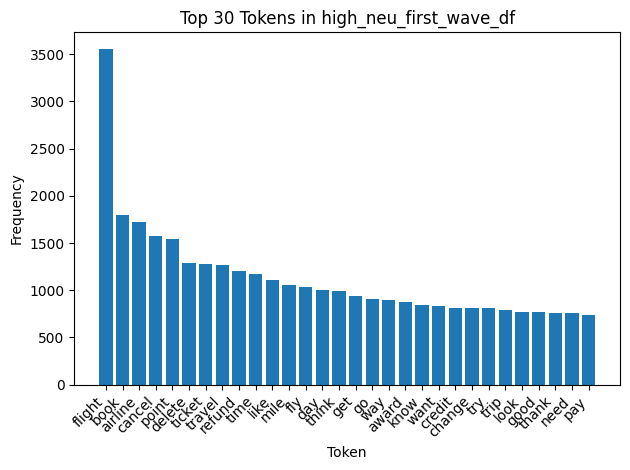

In [81]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [82]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


171869 words total, with a vocabulary size of 11220
Max reddit post length is 326 tokens
Mean reddit post length is 15.14 tokens
Median reddit post length is 9 tokens


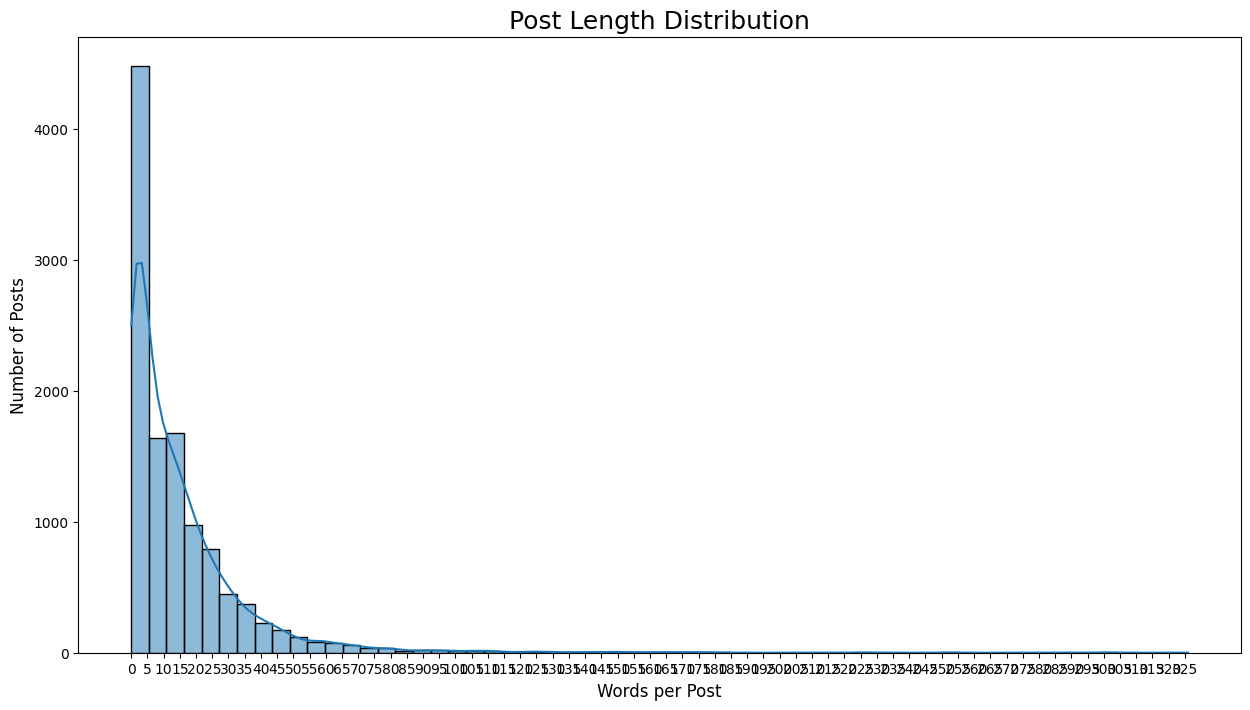

In [83]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

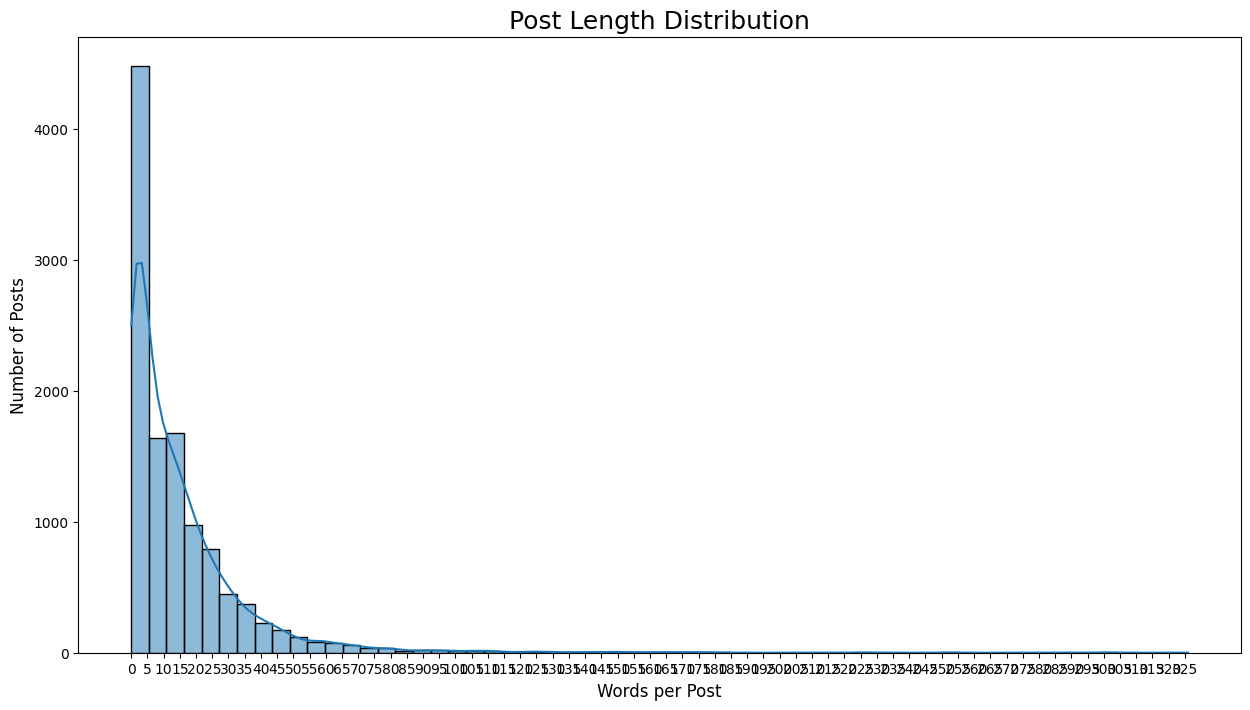

In [84]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [85]:
!pip install  gensim

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim


In [86]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                              tokens  \
0                                 [ill, pay, mosaic]   
1  [redemption, november, right, riding, shoe, mo...   
2  [sure, plan, hilton, redemption, soon, specula...   
3                                            [thank]   
4                                              [big]   

                                       bigram_tokens  \
0                                 [ill, pay, mosaic]   
1  [redemption, november, right, riding, shoe, mo...   
2  [sure, plan, hilton, redemption, soon, specula...   
3                                            [thank]   
4                                              [big]   

                                      trigram_tokens  
0                                 [ill, pay, mosaic]  
1  [redemption, november, right, riding, shoe, mo...  
2  [sure, plan, hilton, redemption, soon, specula...  
3                                            [thank]  
4                                              [big

In [87]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   2428
Rows with trigrams:  131
Rows with no n-grams: 8922


In [88]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
0,2020-05-31,mild neu,0.569819,ill pay mosaic much,"[ill, pay, mosaic]",ill pay mosaic,"[ill, pay, mosaic]","[ill, pay, mosaic]",False,False
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...,"[redemption, november, right, riding, shoe, mo...",redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo...","[redemption, november, right, riding, shoe, mo...",False,False
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...,"[sure, plan, hilton, redemption, soon, specula...",sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula...","[sure, plan, hilton, redemption, soon, specula...",False,False
3,2020-05-31,mild neu,0.576460,thanks,[thank],thank,[thank],[thank],False,False
4,2020-05-31,mild neu,0.629136,bigger w,[big],big,[big],[big],False,False


In [89]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 11350
Number of rows in 'trigram_tokenized' column: 11350


In [90]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 32

Most common trigrams:
remove_contact_mod: 29
bad_case_scenario: 12
credit_card_issuer: 12
star_alliance_partner: 9
original_form_payment: 8
frequent_flyer_number: 8
file_dot_complaint: 5
travel_good_faith: 5
issuer_write_letter: 5
legally_protect_law: 5


In [91]:
#import gensim.corpora as corpora
# Create Dictionary
#id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
#id2word.filter_extremes(no_below=5, no_above=0.5)

#    (Optional) Re-map the remaining token IDs to remove gaps
#id2word.compactify()

# 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [92]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [93]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [94]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
0,2020-05-31,mild neu,0.569819,ill pay mosaic much,"[ill, pay, mosaic]",ill pay mosaic,"[ill, pay, mosaic]","[ill, pay, mosaic]",False,False
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...,"[redemption, november, right, riding, shoe, mo...",redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo...","[redemption, november, right, riding, shoe, mo...",False,False
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...,"[sure, plan, hilton, redemption, soon, specula...",sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula...","[sure, plan, hilton, redemption, soon, specula...",False,False
3,2020-05-31,mild neu,0.576460,thanks,[thank],thank,[thank],[thank],False,False
4,2020-05-31,mild neu,0.629136,bigger w,[big],big,[big],[big],False,False


In [95]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [96]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [97]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
 for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta', 'seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3942, Coherence: 0.7260 ,Alpha: [1.0359843  0.36709943], Eta: [ 1.739629    0.35566548 39.863552   ...  0.38229218  0.43118072
  0.38229218]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3983, Coherence: 0.7196 ,Alpha: [1.2394559 0.6004952], Eta: [ 1.7702157  0.3531874 39.314194  ...  0.3755715  0.4229995  0.3755715]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3990, Coherence: 0.7186 ,Alpha: [1.2444407 0.6192747], Eta: [ 1.7559315   0.35219216 38.847042   ...  0.37410164  0.42119274
  0.37410164]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3757, Coherence: 0.7326 ,Alpha: [0.42167205 0.14722379], Eta: [ 4.663677    0.37952274 48.57549    ...  0.405695    0.46002072
  0.405695  ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3773, Coherence: 0.7326 ,Alpha: [0.5030984  0.15740843], Eta: [ 3.3303046   0.37670243 47.061813   ...  0.402806    0.45642963
  0.402806  ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3776, Coherence: 0.7326 ,Alpha: [0.5167281  0.15930863], Eta: [ 3.1558406   0.37621292 46.774117   ...  0.40230528  0.4558083
  0.40230528]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3669, Coherence: 0.7221 ,Alpha: [0.21873909 0.09828795], Eta: [17.306278    0.39469042 54.920506   ...  0.42180747  0.48016316
  0.42180747]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3678, Coherence: 0.7213 ,Alpha: [0.24928765 0.10302905], Eta: [17.073723    0.39250302 53.84864    ...  0.419416    0.47715992
  0.419416  ]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3681, Coherence: 0.7213 ,Alpha: [0.25773644 0.10499723], Eta: [16.786016    0.39189583 53.554024   ...  0.41874772  0.47632283
  0.41874772]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4054, Coherence: 0.7219 ,Alpha: [0.4340832  0.45448035 0.83082914], Eta: [ 0.42316404  0.22906458 16.924345   ...  0.24465351  0.2586374
  0.24465351]


Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4126, Coherence: 0.7032 ,Alpha: [0.31505302 0.61747116 0.85975814], Eta: [ 0.41996711  0.22926931 12.019853   ...  0.24350843  0.2573879
  0.24350843]


Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4103, Coherence: 0.7140 ,Alpha: [0.379217  0.5989333 0.8821667], Eta: [ 0.41871944  0.2287151  13.856254   ...  0.24452476  0.2584463
  0.24452476]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3935, Coherence: 0.7180 ,Alpha: [0.31812644 0.29483047 0.613145  ], Eta: [ 0.4496959   0.23166735 17.718218   ...  0.24636866  0.26059029
  0.24636866]


Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.4022, Coherence: 0.7026 ,Alpha: [0.27790567 0.5240173  0.7384238 ], Eta: [ 0.4330799   0.23105687 13.254422   ...  0.24426015  0.25825942
  0.24426015]


Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3992, Coherence: 0.7187 ,Alpha: [0.3456929  0.49517047 0.7702018 ], Eta: [ 0.42914474  0.23043905 14.865652   ...  0.24501234  0.2590482
  0.24501234]
Num Topics: 3, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3893, Coherence: 0.7180 ,Alpha: [0.2826433  0.25768876 0.5278554 ], Eta: [ 0.47046465  0.23304042 18.138014   ...  0.2467895   0.26108998
  0.2467895 ]


Num Topics: 3, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3987, Coherence: 0.7016 ,Alpha: [0.26054955 0.47626242 0.6743412 ], Eta: [ 0.44410232  0.23190142 13.704338   ...  0.24420162  0.2582258
  0.24420162]


Num Topics: 3, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3957, Coherence: 0.7187 ,Alpha: [0.3229351 0.4488593 0.7143051], Eta: [ 0.43790802  0.2311096  15.323586   ...  0.24409957  0.25808904
  0.24409957]
Num Topics: 4, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4484, Coherence: 0.6398 ,Alpha: [0.6524559 1.0022848 1.9364842 0.4078536], Eta: [0.23773521 0.1798039  1.456278   ... 0.1862387  0.19230141 0.1862387 ]
Num Topics: 4, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4559, Coherence: 0.6443 ,Alpha: [0.68832505 1.1395856  2.2183847  0.44178584], Eta: [0.23799162 0.18065608 0.52788866 ... 0.18581063 0.19193023 0.18581063]
Num Topics: 4, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4636, Coherence: 0.6337 ,Alpha: [0.68714494 1.3898851  2.2622533  0.46467066], Eta: [0.23831916 0.18103419 0.5217026  ... 0.18640174 0.19251344 0.18640174]
Num Topics: 4, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4397

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3809, Coherence: 0.7096 ,Alpha: [0.504172   0.63329035], Eta: [16.496292    0.36603287 40.947754   ...  0.39976043  0.4544376
  0.39976043]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3810, Coherence: 0.7096 ,Alpha: [0.52619016 0.6385469 ], Eta: [16.531837    0.3684294  40.76031    ...  0.40021408  0.45508114
  0.40021408]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3811, Coherence: 0.7096 ,Alpha: [0.53882617 0.6417816 ], Eta: [16.51927     0.36980143 40.62428    ...  0.40029734  0.45522112
  0.40029734]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3576, Coherence: 0.6974 ,Alpha: [0.12711121 0.13243699], Eta: [21.01609     0.3885099  52.151264   ...  0.41524607  0.4719785
  0.41524607]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3571, Coherence: 0.7009 ,Alpha: [0.1234251 0.1277058], Eta: [21.093594    0.38900495 52.374767   ...  0.4158004   0.47267225
  0.4158004 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3570, Coherence: 0.7009 ,Alpha: [0.12360067 0.12751362], Eta: [21.089436    0.38899842 52.371807   ...  0.41579202  0.47266206
  0.41579202]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3537, Coherence: 0.7009 ,Alpha: [0.11100089 0.11344285], Eta: [21.58756     0.3933218  53.583214   ...  0.42008772  0.4780507
  0.42008772]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3531, Coherence: 0.7009 ,Alpha: [0.10789904 0.10995823], Eta: [21.661621    0.39380702 53.778748   ...  0.42063138  0.47873172
  0.42063138]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3531, Coherence: 0.7009 ,Alpha: [0.10770739 0.10925246], Eta: [21.658613    0.3938412  53.788124   ...  0.42066815  0.47877812
  0.42066815]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3899, Coherence: 0.6966 ,Alpha: [0.8561214  0.36074147 0.1793657 ], Eta: [0.43466634 0.239253   1.786537   ... 0.23937668 0.25310615 0.23937668]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3917, Coherence: 0.6649 ,Alpha: [0.9505571  0.3422705  0.15719049], Eta: [0.42108423 0.23209642 1.7157158  ... 0.23976369 0.2535442  0.23976369]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3951, Coherence: 0.6192 ,Alpha: [1.0479512  0.3751055  0.14917263], Eta: [0.41521192 0.23115918 1.6665877  ... 0.23867    0.2523316  0.23867   ]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3791, Coherence: 0.6943 ,Alpha: [0.742225

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3748, Coherence: 0.6490 ,Alpha: [0.13890672 0.56787026], Eta: [ 9.712731    0.35811344 17.585613   ...  0.3871525   0.4371301
  0.3871525 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3749, Coherence: 0.6490 ,Alpha: [0.13743617 0.5700917 ], Eta: [ 9.458433    0.3579376  16.76156    ...  0.3869763   0.43691197
  0.3869763 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3745, Coherence: 0.6490 ,Alpha: [0.13500205 0.5621028 ], Eta: [ 9.445168    0.35856286 16.760614   ...  0.38763     0.4377163
  0.38763   ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3552, Coherence: 0.6889 ,Alpha: [0.07997342 0.2170315 ], Eta: [16.580294    0.3867253  37.354904   ...  0.41649297  0.47368866
  0.41649297]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3550, Coherence: 0.6946 ,Alpha: [0.07777463 0.21378942], Eta: [16.56428     0.38705778 37.282528   ...  0.41690502  0.4742044
  0.41690502]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3539, Coherence: 0.6946 ,Alpha: [0.07393777 0.19988266], Eta: [16.675488    0.38862395 37.903244   ...  0.41865748  0.47639757
  0.41865748]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3514, Coherence: 0.6945 ,Alpha: [0.06993004 0.17495437], Eta: [17.42224     0.39215514 41.192738   ...  0.4219136   0.48048633
  0.4219136 ]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3508, Coherence: 0.6945 ,Alpha: [0.06672994 0.1699119 ], Eta: [17.526012    0.39296088 41.344048   ...  0.42288148  0.4817009
  0.42288148]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3502, Coherence: 0.6931 ,Alpha: [0.06462238 0.1639608 ], Eta: [17.531801    0.39375597 41.958607   ...  0.42373338  0.48276672
  0.42373338]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3923, Coherence: 0.6910 ,Alpha: [0.1791659 0.5811082 0.7800649], Eta: [1.2915906  0.23357324 1.7883285  ... 0.23950106 0.25315738 0.23950106]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3970, Coherence: 0.5983 ,Alpha: [0.16795069 0.538338   0.92402685], Eta: [1.158109   0.25500682 1.7033944  ... 0.23951492 0.25316432 0.23951492]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4011, Coherence: 0.5881 ,Alpha: [0.16574982 0.4930189  0.99872696], Eta: [1.1131922  0.28506505 1.6416289  ... 0.23913005 0.252729   0.23913005]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3820, Coherence: 0.7104 ,Alpha: [0.155951   

In [98]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.7326
 Perplexity: -7.3757
 Alpha (per topic): [0.42167205 0.14722379]
 Eta   (per word):  [ 4.663677    0.37952274 48.57549    ...  0.405695    0.46002072
  0.405695  ]


In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_neutral_1st_wave.gensim')


In [100]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_1st_mild_neu.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary_1st_mild_neu.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [101]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [102]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.019*"flight" + 0.012*"cancel" + 0.012*"airline" + 0.011*"delete" + '
  '0.010*"refund" + 0.010*"travel" + 0.008*"point" + 0.007*"time" + '
  '0.007*"book" + 0.006*"get"'),
 (1,
  '0.025*"flight" + 0.014*"mile" + 0.013*"book" + 0.012*"fly" + 0.012*"ticket" '
  '+ 0.012*"seat" + 0.011*"award" + 0.009*"airline" + 0.008*"way" + '
  '0.007*"time"')]

Sample doc-topic distribution for doc 0:
[(0, 0.9585049), (1, 0.041495074)]


In [103]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [104]:

print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  flight (0.0187)
  cancel (0.0124)
  airline (0.0122)
  delete (0.0111)
  refund (0.0101)
  travel (0.0096)
  point (0.0076)
  time (0.0068)
  book (0.0065)
  get (0.0064)
  thank (0.0063)
  day (0.0060)
  go (0.0059)
  like (0.0059)
  change (0.0057)
  think (0.0057)
  ticket (0.0056)
  know (0.0055)
  want (0.0048)
  try (0.0047)
  people (0.0047)
  trip (0.0044)
  ask (0.0044)
  say (0.0043)
  need (0.0042)
  year (0.0041)
  sure (0.0041)
  credit (0.0041)
  pay (0.0039)
  use (0.0038)

Topic 2:
  flight (0.0245)
  mile (0.0139)
  book (0.0131)
  fly (0.0120)
  ticket (0.0119)
  seat (0.0116)
  award (0.0111)
  airline (0.0091)
  way (0.0075)
  time (0.0073)
  point (0.0069)
  look (0.0066)
  find (0.0064)
  check (0.0063)
  availability (0.0061)
  transfer (0.0059)
  fare (0.0058)
  route (0.0057)
  united (0.0054)
  price (0.0051)
  like (0.0050)
  think (0.0050)
  good (0.0048)
  airport (0.0048)
  pay (0.0045)
  cheap (0.0045)
  bag (0.0

In [105]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [106]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()

#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [107]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [108]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [109]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [110]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [111]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [112]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [113]:
# ## FIND THE OPTIMAL TOPIC

# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd

# # Assuming high_neu_first_wave_df['lemmatized_bigrams'] contains lists of lemmatized bigram tokens
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Create a Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics):
#     lda_model = LdaModel(corpus=corpus,
#                                        id2word=dictionary,
#                                        num_topics=num_topics,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)
#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#     return perplexity, coherence

# # Testing different numbers of topics
# results = []
# for num_topics in range(2, 12):  # You can adjust the range based on your needs
#     perplexity, coherence = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics)
#     results.append((num_topics, perplexity, coherence))

# # Display results
# print("Num Topics | Perplexity | Coherence")
# for result in results:
#     print(f"{result[0]:10d} | {result[1]:10.4f} | {result[2]:10.4f}")

# # Optional: find the number of topics with the highest coherence
# optimal_num_topics = sorted(results, key=lambda x: x[2], reverse=True)[0][0]
# print(f"Optimal Number of Topics: {optimal_num_topics}")


In [114]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()